In [ ]:
import numpy as np
import pandas as pd
import os
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D
# from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Activation, Flatten, Input, concatenate, Conv1D, GlobalMaxPooling1D, MaxPooling1D,BatchNormalization

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link="https://drive.google.com/file/d/14dq1MXs4o0OO0bqTzEB2_qXqJcuvMh3Z/view?usp=sharing"
id = link.split("/")[-2]
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('tweet_emotions.csv')
df = pd.read_csv('tweet_emotions.csv')

In [ ]:
import nltk
from nltk.metrics.distance import jaccard_distance
from nltk.util import ngrams

nltk.download('words')
from nltk.corpus import words

correct_words = words.words()


def spelling_fix(text):
    new_text = []
    incorrect_words = nltk.word_tokenize(text)
    for word in incorrect_words:
        temp = [(jaccard_distance(set(ngrams(word, 2)),
                                  set(ngrams(w, 2))),w)
                for w in correct_words if w[0]==word[0]]
        most_similar_list = sorted(temp, key = lambda val:val[0])

        if len(most_similar_list) == 0:
            new_text.append(word)
            continue

        if most_similar_list[0][0] >= 0.9:
            new_text.append(most_similar_list[0][1])
        else:
            new_text.append(word)

    return " ".join(new_text)

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [ ]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


wordnet_lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


def remove_emoji(text):
    regex_pattern = re.compile("["
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U0001F1E6-\U0001F1FF"  # flags
                               "]+", flags=re.UNICODE)

    return regex_pattern.sub(r'', text)


def remove_email(text):
    return re.sub('([A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,})', '', text)


def remove_repeated_char(text):
    return re.sub(r'(.)\1\1{1,}', r'\1\1', text)


def remove_account_tag(text):
    return re.sub(r'@[\w]+', '', text)


def remove_hashtag(text):
    return re.sub(r'#[\w]+', '', text)


def remove_links(text):
    return re.sub(r'http[^\s]+', '', text)


def remove_spaces(text):
    text = re.sub(r"\d+", ' ', text)
    text = re.sub(r"\n+", ' ', text)
    text = re.sub(r"\t+", ' ', text)
    text = re.sub(r"\r+", ' ', text)
    text = re.sub(r"\s+", ' ', text)
    return text


def remove_stop_words(text):
    word_tokens = word_tokenize(text)
    return " ".join([w for w in word_tokens if not w in stop_words])


def remove_less_2_characters(text):
    return re.sub(r"\W*\b\w{1,2}\b", '', text)


def lemmatize(text):
    new_text = []
    tokenization = nltk.word_tokenize(text)
    for w in tokenization:
        tmp_w = wordnet_lemmatizer.lemmatize(w)
        if tmp_w is None:
            new_text.append(w)
        else:
            new_text.append(tmp_w)
    return " ".join(new_text)


def preprocess_text_sample(text):
    text = remove_emoji(text)
    text = remove_email(text)
    text = remove_repeated_char(text)
    text = remove_account_tag(text)
    text = remove_hashtag(text)
    text = remove_links(text)
    text = remove_stop_words(text)
    text = remove_spaces(text)
    text = remove_less_2_characters(text)
    text = text.strip()
    text = text.lower()
    #text = spelling_fix(text)
    text = lemmatize(text)
    return text


def preprocess_text_cols(df, col):
    df[col] = df[col].apply(lambda x: preprocess_text_sample(x))
    return df


def preprocess_df(df, col="content"):
    df = preprocess_text_cols(df, col)
    df.dropna(inplace=True)
    return df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df["sentiment"].value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (12,6))
sns.countplot(df["sentiment"], palette='Set3')

ValueError: ignored

<Figure size 1200x600 with 0 Axes>

In [ ]:
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder


def get_label_encoder_obj(y):
    label_encoder = LabelEncoder()
    return label_encoder.fit(y)


def get_y_label_encoder(label_encoder, y):
    return label_encoder.transform(y)


def get_label_decoder(label_encoder, y):
    return label_encoder.classes_[y]


def one_hot_encode(y, num_classes):
    return to_categorical(y, num_classes=num_classes)

In [ ]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(df, test_size=0.1, random_state=2, stratify=df["sentiment"])

In [ ]:
label_encoder = get_label_encoder_obj(train["sentiment"])
train["sentiment"] = get_y_label_encoder(label_encoder, train["sentiment"])
val["sentiment"] = get_y_label_encoder(label_encoder, val["sentiment"])

In [ ]:
num_classes = len(np.unique(train["sentiment"]))
num_classes

13

In [ ]:
X_train = train["content"].values
y_train = train["sentiment"].values
X_val = val["content"].values
y_val = val["sentiment"].values
X_test = val["content"].values
y_test = val["sentiment"].values

In [ ]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [ ]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
oov_tok = '<OOV>'
padding_type = 'post'

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [ ]:
vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 45559


In [ ]:
sequences = tokenizer.texts_to_sequences(X_train)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)
testing_sentences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sentences, maxlen=max_length)

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length)),
model.add(Conv1D(256,5,padding='valid',activation='relu',strides=1))
model.add(MaxPooling1D(pool_size=2))
model.add (BatchNormalization()),
model.add (Dropout(0.3)),
model.add(Conv1D(128, 5,padding='valid',activation='relu',strides=1))
model.add(MaxPooling1D(pool_size=2))
model.add (BatchNormalization()),
model.add (Dropout(0.3)),
model.add(LSTM(128))
model.add (Dropout(0.3)),
model.add(Dense(32))
model.add (Dropout(0.3)),
model.add(Dense(13))
model.add(Activation('softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 conv1d (Conv1D)             (None, 116, 256)          20736     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 58, 256)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 58, 256)          1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 58, 256)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 54, 128)           1

In [ ]:
training_labels_final = np.array(y_train)
testing_labels_final = np.array(y_test)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(padded, training_labels_final, epochs=30, validation_data=(testing_padded, testing_labels_final))

Epoch 1/20
1125/1125 [==============================] - 148s 132ms/step - loss: 0.9233 - accuracy: 0.6932 - val_loss: 3.4005 - val_accuracy: 0.2720
Epoch 2/20
1125/1125 [==============================] - 144s 128ms/step - loss: 0.9006 - accuracy: 0.7006 - val_loss: 3.5990 - val_accuracy: 0.2735
Epoch 3/20
1125/1125 [==============================] - 145s 129ms/step - loss: 0.8757 - accuracy: 0.7063 - val_loss: 3.5731 - val_accuracy: 0.2645
Epoch 4/20
1125/1125 [==============================] - 147s 131ms/step - loss: 0.8588 - accuracy: 0.7142 - val_loss: 3.7155 - val_accuracy: 0.2693
Epoch 5/20
1125/1125 [==============================] - 144s 128ms/step - loss: 0.8382 - accuracy: 0.7201 - val_loss: 3.7010 - val_accuracy: 0.2673
Epoch 6/20
1125/1125 [==============================] - 150s 133ms/step - loss: 0.8318 - accuracy: 0.7258 - val_loss: 3.7255 - val_accuracy: 0.2643
Epoch 7/20
1125/1125 [==============================] - 153s 136ms/step - loss: 0.8079 - accuracy: 0.7298 - val_

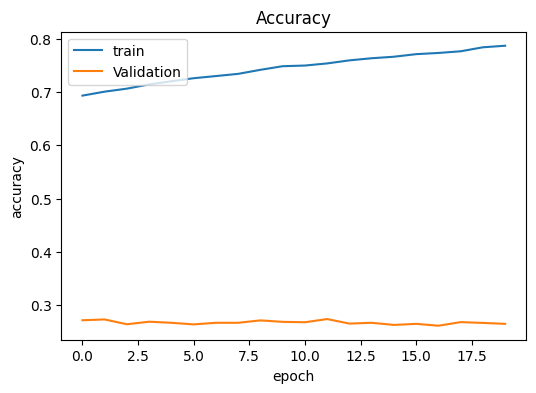

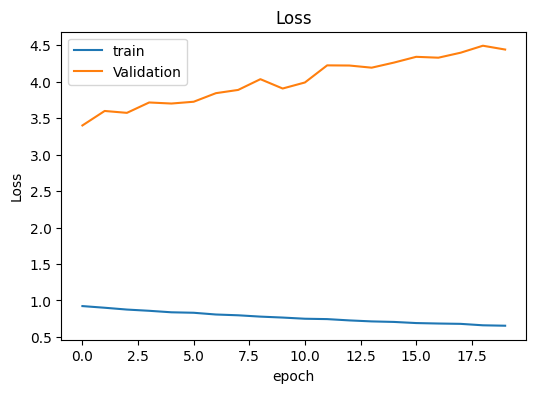

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()